# Exploratory Data Analysis (EDA) for Beijing pm2.5 datasets

reference: https://www.kaggle.com/stephaniestallworth/housing-feature-engineering-regression  
http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib
#resize the inline figure
matplotlib.rcParams['figure.figsize'] = [12, 9]

In [57]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
#         names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        names += [(var_name + '(t-%d)' % (i)) for j, var_name in enumerate(df.columns.values)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [var_name + '(t)' for j, var_name in enumerate(df.columns.values)]
        else:
            names += [(var_name + '(t+%d)' % (i)) for j, var_name in enumerate(df.columns.values)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
raw_data = pd.read_csv("raw_data_new.csv", parse_dates=[0], index_col=0)
raw_data.head()

,pm25,t2m,d2m,u10,v10,sp,t500,t850,t1000,q500,...,q1000,u500,u850,u1000,v500,v850,v1000,w500,w850,w1000
2016-01-01 08:00:00,106.0,266.158697,262.942797,0.610000,-0.854401,99031.629452,247.480585,273.959647,273.713458,0.000186,...,0.001782,22.726637,9.640619,1.023143,0.605482,-0.931638,-0.915407,-0.059048,0.167941,0.137051
2016-01-01 14:00:00,172.0,277.572013,265.854378,0.539951,0.014327,98687.355922,247.663581,275.492070,277.549782,0.000182,...,0.001889,22.448769,9.815926,0.449519,0.500462,-1.817629,0.066058,0.046678,0.081981,0.016615
2016-01-01 20:00:00,260.0,271.109503,266.588183,1.231592,-0.007235,98736.579464,249.138077,274.646867,279.338926,0.000219,...,0.002003,21.773777,7.522623,1.202028,-3.983918,-4.214963,0.149120,-0.120461,0.238271,0.090715
2016-01-02 02:00:00,306.0,266.704619,264.173029,0.891609,-1.404387,98683.278232,247.929517,274.961514,277.894709,0.000442,...,0.001956,21.577004,7.068256,1.506132,-4.629317,-2.406700,-2.123144,-0.105199,-0.051509,0.186144
2016-01-02 08:00:00,195.0,266.042011,262.649275,0.834297,-1.433449,98634.054690,246.955296,274.261128,276.341222,0.000588,...,0.001608,22.702786,5.349770,1.060113,-6.598931,-1.580856,-2.603374,0.018822,-0.022825,0.212162


In [5]:
df_corr = raw_data.corr()
df_corr['pm25'][1:].sort_values(ascending=False)

v850     0.278754
v1000    0.255704
v500     0.251433
v10      0.247893
u850     0.144769
d2m      0.074900
t850     0.066519
t500     0.023324
u500     0.013723
q1000    0.012299
q850     0.002476
t1000   -0.019663
sp      -0.052549
u10     -0.053391
q500    -0.056409
w500    -0.059093
t2m     -0.060261
u1000   -0.073105
w850    -0.161677
w1000   -0.227673
Name: pm25, dtype: float64

In [6]:
data = series_to_supervised(raw_data, 8, 1)

In [7]:
# Compute correlation with pm25
data.corr()['pm25(t)'][1:].sort_values(ascending=False)

pm25(t)       1.000000
pm25(t-1)     0.735222
pm25(t-2)     0.569053
pm25(t-3)     0.477729
pm25(t-4)     0.398215
v850(t-1)     0.343191
v1000(t-1)    0.341042
v850(t-2)     0.337778
v10(t-1)      0.330204
v1000(t-2)    0.303273
v850(t-3)     0.292876
v10(t-2)      0.291343
pm25(t-5)     0.289206
v850(t)       0.282788
v1000(t)      0.262030
v10(t)        0.254534
v500(t)       0.253504
v1000(t-3)    0.252670
v10(t-3)      0.248813
v850(t-4)     0.238963
v1000(t-4)    0.236651
v10(t-4)      0.231681
pm25(t-6)     0.207440
v1000(t-5)    0.199546
v500(t-1)     0.193336
v10(t-5)      0.188202
u850(t-1)     0.180257
v850(t-5)     0.176640
u850(t-2)     0.173814
pm25(t-7)     0.173648
                ...   
t2m(t-3)     -0.101493
t1000(t-7)   -0.102093
d2m(t-8)     -0.102356
w850(t-4)    -0.103347
q500(t-3)    -0.105118
t1000(t-8)   -0.106063
t2m(t-6)     -0.107458
q1000(t-7)   -0.109926
q850(t-7)    -0.114944
q1000(t-8)   -0.117222
v500(t-7)    -0.119765
q500(t-4)    -0.120867
q850(t-8)  

## Data visualizing 

春:
75.99691833590138
夏:
54.97400611620795
秋：
75.10917030567686
冬：
79.8179104477612


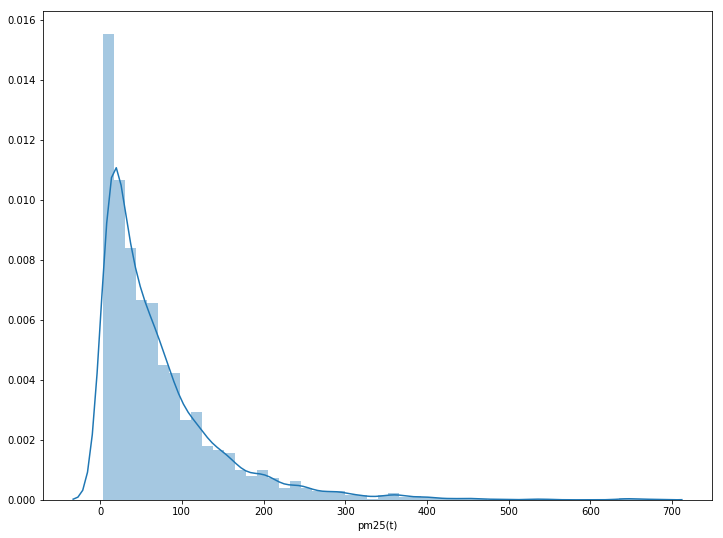

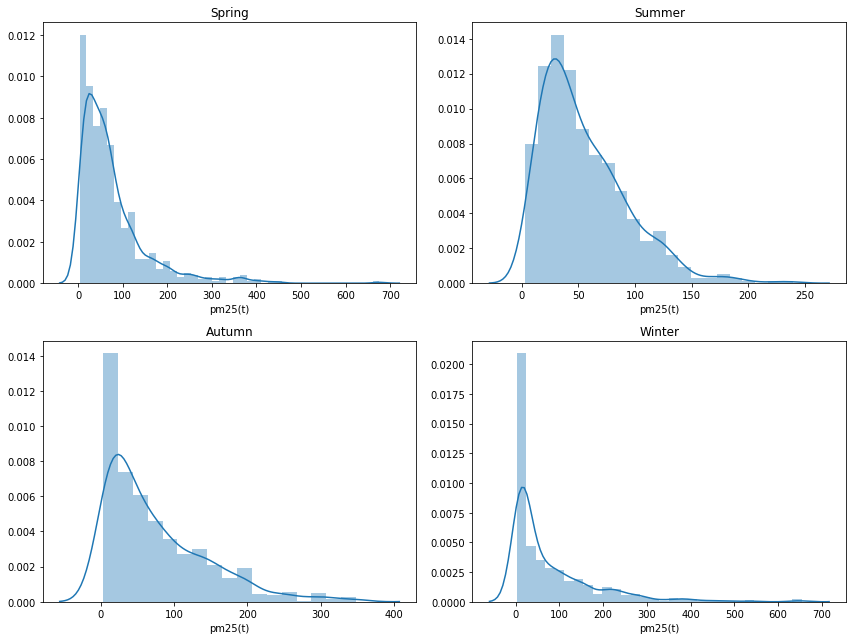

In [94]:
#pm2.5频率分布直方图，及四季频率分布直方图
pm25_data = data['pm25(t)']
time_index = pm25_data.index
sns.distplot(pm25_data)
plt.savefig('fig1.png')

f, axes = plt.subplots(2, 2)
spring_pm25 = pm25_data[(time_index.month == 3) | (time_index.month == 4) |  (time_index.month == 5)]
sns.distplot(spring_pm25, ax=axes[0,0])
axes[0,0].set_title('Spring')

summer_pm25 = pm25_data[(time_index.month == 6) | (time_index.month == 7) |  (time_index.month == 8)]
sns.distplot(summer_pm25, ax=axes[0,1])
axes[0,1].set_title('Summer')

autumn_pm25 = pm25_data[(time_index.month == 9) | (time_index.month == 10) |  (time_index.month == 11)]
sns.distplot(autumn_pm25, ax=axes[1,0])
axes[1,0].set_title('Autumn')

winter_pm25 = pm25_data[(time_index.month == 12) | (time_index.month == 1) |  (time_index.month == 2)]
sns.distplot(winter_pm25, ax=axes[1,1])
axes[1,1].set_title('Winter')

plt.tight_layout()
plt.savefig('fig2.png')

#平均值
print("春:")
print(spring_pm25.mean())
print("夏:")
print(summer_pm25.mean())
print("秋：")
print(autumn_pm25.mean())
print("冬：")
print(winter_pm25.mean())

In [75]:
#计算空气质量等级
def air_quality_rank(x):
    """
    根据国标，计算一级到六级空气质量
    """
    if x <= 50:
        return 1
    elif x <= 100:
        return 2
    elif x <= 150:
        return 3
    elif x <= 200:
        return 4
    elif x <= 300:
        return 5
    else:
        return 6

# pm25_data['rank'] = pm25_data.apply(air_quality_rank)
pm25_data = pd.concat((pm25_data, pm25_data.apply(air_quality_rank)), axis = 1)

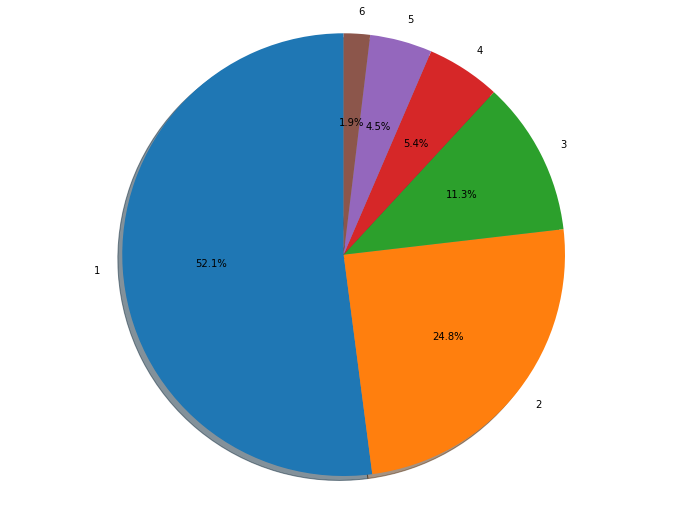

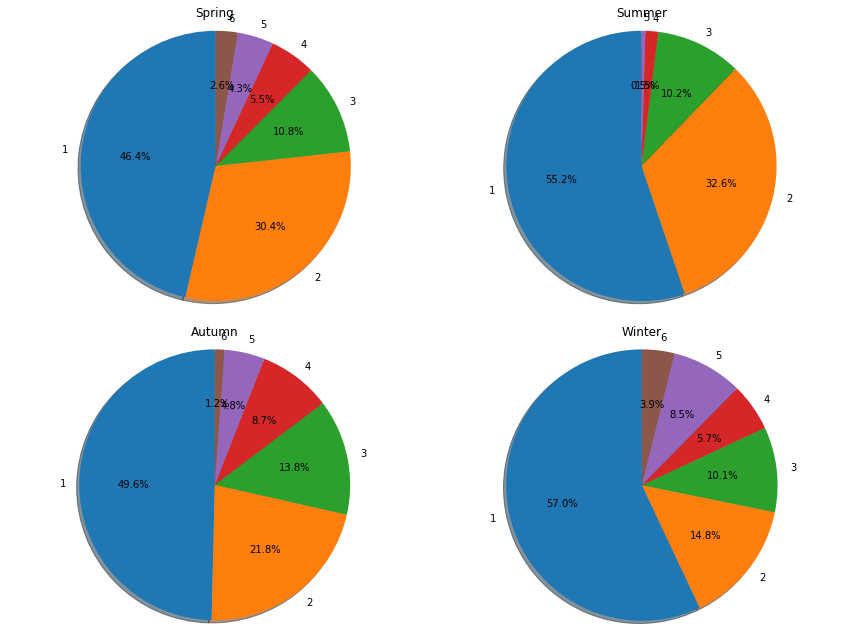

In [77]:
#画出空气质量等级饼图，及四季饼图
pm25_data.columns = ('pm25', 'rank')
counts_data = pm25_data.groupby('rank').size().reset_index(name='counts')
counts = counts_data['counts']

fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.savefig('fig3.png')

def calculate_counts(input_data):
    """
    Calculate the rank counts of pm25 data
    """
    df = pd.concat((input_data, input_data.apply(air_quality_rank)), axis = 1)
    df.columns = ('pm25', 'rank')
    counts_data = df.groupby('rank').size().reset_index(name='counts')
    return counts_data['counts']
    

fig2, axes = plt.subplots(2, 2)
axes[0, 0].pie(calculate_counts(spring_pm25), labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[0, 0].axis('equal') 
axes[0, 0].set_title('Spring')

axes[0, 1].pie(calculate_counts(summer_pm25), labels=[1,2,3,4,5], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[0, 1].axis('equal') 
axes[0, 1].set_title('Summer')

axes[1, 0].pie(calculate_counts(autumn_pm25), labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[1, 0].axis('equal') 
axes[1, 0].set_title('Autumn')

axes[1, 1].pie(calculate_counts(winter_pm25), labels=[1,2,3,4,5,6], autopct='%1.1f%%',
        shadow=True, startangle=90)
axes[1, 1].axis('equal') 
axes[1, 1].set_title('Winter')

plt.tight_layout()
plt.savefig('fig4.png')

# Feature Engineering
Select most important features affecting pm2.5 of Beijing

In [61]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [62]:
#(189: 21 * 8 + 21)
X = data.iloc[:, :21*8]
y = data.iloc[:, 21*8]

In [63]:
# Select top 20% features according to f_regression score. 根据f score选出最重要的20%因子 
#TODO: f_regression只能衡量变量间的线性关系，mutual_info_regression可以衡量非线性关系。可尝试mutual_info_regression
selector_f = SelectPercentile(f_regression, percentile=20)
x_best = selector_f.fit_transform(X, y)

In [64]:
support = selector_f.get_support()
# Column names of top 20%
features = np.asarray(X.columns.values)
features_with_support = features[support]

#f-scores of top 20%
fscores = np.asarray(selector_f.scores_)
fscores_with_support = fscores[support]

# p-values of top 20%
pvalues = np.asarray(selector_f.pvalues_)
pvalues_with_support = pvalues[support]

In [65]:
# Dataframe of top 20%
top20 = pd.DataFrame({'F-score':fscores_with_support,
                      'p-value':pvalues_with_support},
                     index = features_with_support)
# top20.index.name = 'Feature'
print('Top 20% best associated features to pm25\nNumber of features:',len(features_with_support))
print(top20.sort_values(by = 'p-value', ascending = 'True'))

Top 20% best associated features to pm25
Number of features: 34
                F-score        p-value
pm25(t-1)   3127.188973   0.000000e+00
pm25(t-2)   1272.915543  3.850773e-228
pm25(t-3)    786.010643  9.655012e-152
pm25(t-4)    500.926758  8.592816e-102
v850(t-1)    354.854338   2.111024e-74
v1000(t-1)   349.840338   1.943322e-73
v850(t-2)    342.318003   5.469784e-72
v10(t-1)     325.282004   1.082288e-68
v1000(t-2)   269.230038   1.043752e-57
w1000(t-1)   261.359886   3.787012e-56
v850(t-3)    249.384987   9.117975e-54
v10(t-2)     246.539010   3.368383e-53
pm25(t-5)    242.606571   2.053797e-52
w1000(t-2)   212.878215   1.925233e-46
v1000(t-3)   181.264102   5.102390e-40
v10(t-3)     175.410020   8.047242e-39
v850(t-4)    160.972943   7.436753e-36
v1000(t-4)   157.688580   3.535159e-35
v10(t-4)     150.764029   9.521136e-34
w1000(t-3)   141.102672   9.569315e-32
pm25(t-6)    119.520796   3.034990e-27
w1000(t-4)   117.063195   9.938629e-27
v1000(t-5)   110.226906   2.711759e-25


p-value 均小于0.05，故而这些feature都有统计显著性

## Feature to Feature Correlation
reduce redundancy, colinearity （分析变量间的相关关系，减少冗余信息，减少共线性）

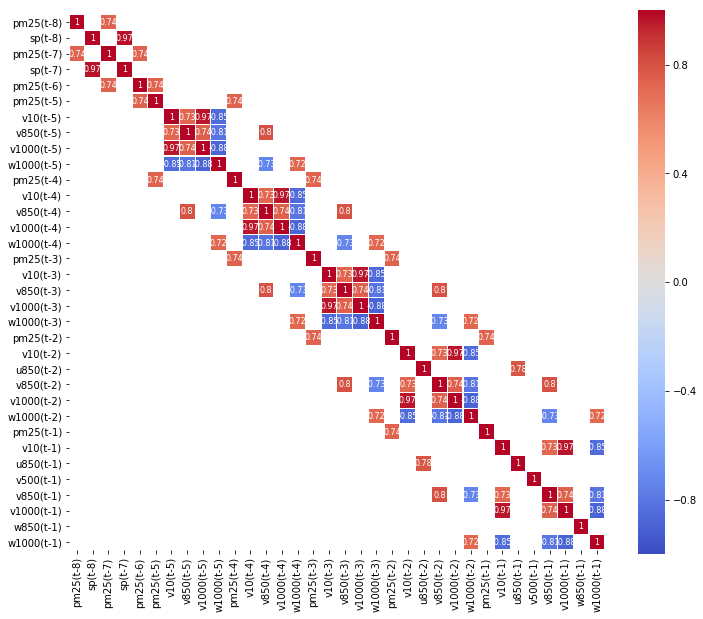

In [78]:

best_feat = data[features_with_support]
# 计算自变量间的相关系数
corr =best_feat.corr() 
plt.figure(figsize=(12, 10))

# 用heatmap画出大于0.7的相关系数
sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

plt.savefig('correlation_1.png')

我们的目的是，对相关系数大于0.8的因子对，只保留其中一个因子。
如何舍弃呢？用下面的与pm2.5的相关系数大小衡量。与pm2.5相关性高的保留，否则去掉

In [67]:
# Correlation with pm25
pd.concat([data[features_with_support], data['pm25(t)']], axis=1).corr()['pm25(t)'][1:].sort_values(ascending=False)

pm25(t)       1.000000
pm25(t-1)     0.735222
pm25(t-2)     0.569053
pm25(t-3)     0.477729
pm25(t-4)     0.398215
v850(t-1)     0.343191
v1000(t-1)    0.341042
v850(t-2)     0.337778
v10(t-1)      0.330204
v1000(t-2)    0.303273
v850(t-3)     0.292876
v10(t-2)      0.291343
pm25(t-5)     0.289206
v1000(t-3)    0.252670
v10(t-3)      0.248813
v850(t-4)     0.238963
v1000(t-4)    0.236651
v10(t-4)      0.231681
pm25(t-6)     0.207440
v1000(t-5)    0.199546
v500(t-1)     0.193336
v10(t-5)      0.188202
u850(t-1)     0.180257
v850(t-5)     0.176640
u850(t-2)     0.173814
pm25(t-7)     0.173648
sp(t-8)       0.164619
sp(t-7)       0.156743
w1000(t-5)   -0.165814
w850(t-1)    -0.172271
w1000(t-4)   -0.205387
w1000(t-3)   -0.224522
w1000(t-2)   -0.272307
w1000(t-1)   -0.299210
Name: pm25(t), dtype: float64

In [68]:
# v10(t-5) vs v1000(t-5) vs w1000(t-5): 保留 v1000(t-5)
# sp(t-7) vs sp(t-8): drop sp(t-7)
# v850(t-4) vs v850(t-5): drop v850(t-5)
# v10(t-4) vs v1000(t-4) vs w1000(t-4):  保留v1000(t-4)
# v10(t-3) vs v1000(t-3) vs w1000(t-3): 保留v1000(t-3)
# v10(t-2) vs v1000(t-2) vs w1000(t-2): 保留v1000(t-2)
# v850(t-1) vs v850(t-2): drop v850(t-2)
# v850(t-1) vs v10(t-1) vs v1000(t-1): drop v10(t-1), v1000(t-1)
# v850(t-1) vs w1000(t-1): drop w1000(t-1)
# v850(t-3) vs v850(t-4): drop v850(t-4)
best_feat = best_feat.drop(['v10(t-5)', 'w1000(t-5)', 'sp(t-7)', 'v850(t-5)', 'v10(t-4)', 'w1000(t-4)',
                           'v10(t-3)', 'w1000(t-3)', 'v10(t-2)', 'w1000(t-2)', 'v850(t-2)', 'v10(t-1)', 'v1000(t-1)', 'w1000(t-1)', 'v850(t-4)'], axis=1)

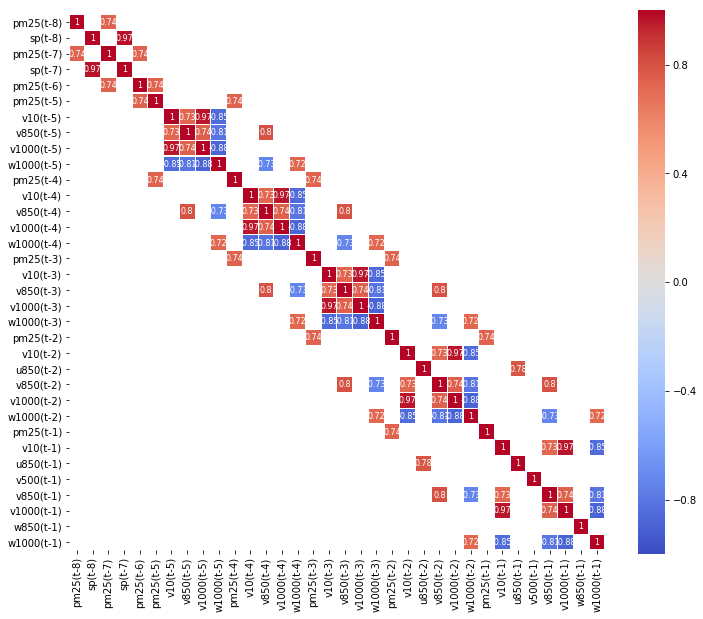

In [79]:
corr =best_feat.corr() # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='coolwarm', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);
plt.savefig('correlation_2.png')

In [17]:
# These are the most important features affecting pm2.5!
best_feat.columns

Index(['pm25(t-8)', 'sp(t-8)', 'pm25(t-7)', 'pm25(t-6)', 'pm25(t-5)',
       'v1000(t-5)', 'pm25(t-4)', 'v1000(t-4)', 'pm25(t-3)', 'v850(t-3)',
       'v1000(t-3)', 'pm25(t-2)', 'u850(t-2)', 'v1000(t-2)', 'pm25(t-1)',
       'u850(t-1)', 'v500(t-1)', 'v850(t-1)', 'w850(t-1)'],
      dtype='object')

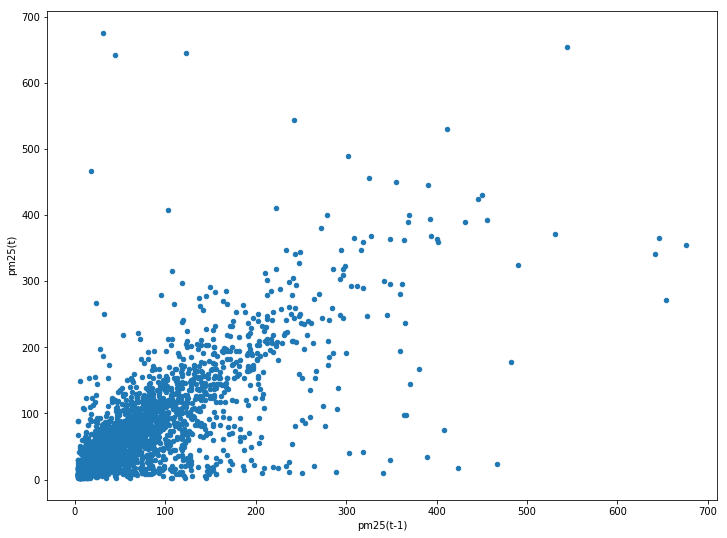

In [80]:
# 画出某个feature与pm2.5之间的散点图
var = 'pm25(t-1)'
data_combined = pd.concat([best_feat[var], data['pm25(t)']], axis=1)
data.plot.scatter(x=var, y='pm25(t)')
plt.savefig('scatter_1.png')

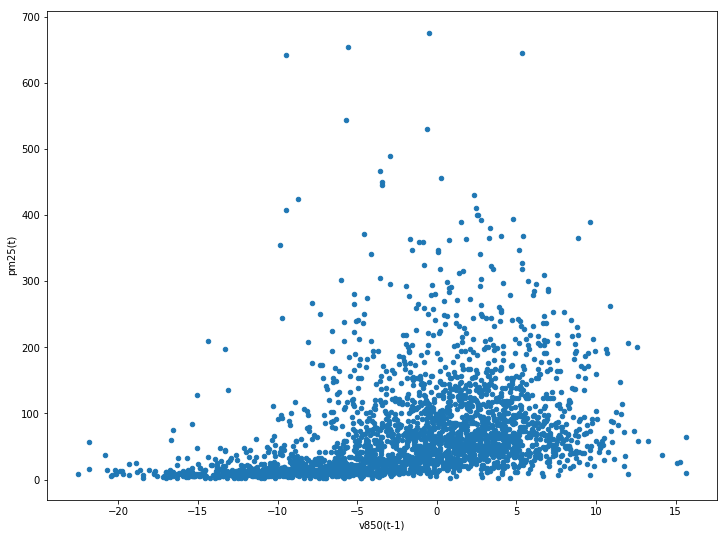

In [81]:
# 画出某个feature与pm2.5之间的散点图
var = 'v850(t-1)'
data_combined = pd.concat([best_feat[var], data['pm25(t)']], axis=1)
data.plot.scatter(x=var, y='pm25(t)')
plt.savefig('scatter_2.png')

## Preprocessing

In [7]:
# normalize data 数据归一化
train_data = pd.concat([best_feat, data['pm25(t)']], axis=1)
values = train_data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

train, test = train_test_split(scaled, test_size=0.2)
train_X = train[:, :19]
train_y = train[:,19]
test_X = test[:, :19]
test_y = test[:,19]

reg = linear_model.LinearRegression()
reg.fit(train_X, train_y)
y_predict1 = reg.predict(test_X)



NameError: name 'best_feat' is not defined

## Training (Linear regression, Random Forest, SVR)

In [198]:
rmse_list1 = []
rmse_list2 = []
rmse_list3 = []
for i in range(5):
    print(i)
    train, test = train_test_split(scaled, test_size=0.2)
    train_X = train[:, :19]
    train_y = train[:,19]
    test_X = test[:, :19]
    test_y = test[:,19]
    # linear regression
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y)
    y_predict1 = reg.predict(test_X)
    
    # random forest
#     rforest = RandomForestRegressor(n_estimators = 300, random_state = 0) 
#     rforest.fit(train_X, train_y)
#     y_predict2 = rforest.predict(test_X)
    
    #SVR
    clf = svm.SVR(kernel='rbf', C=1e5, gamma=1e-6)
    clf.fit(train_X, train_y)
    y_predict3 = clf.predict(test_X)
    
    RMSE1 = math.sqrt(mean_squared_error(inv_normalization(y_predict1), inv_normalization(test_y)))
#     RMSE2 = math.sqrt(mean_squared_error(y_predict2, test_y))
    RMSE3 = math.sqrt(mean_squared_error(inv_normalization(y_predict3), inv_normalization(test_y)))
    
    rmse_list1.append(RMSE1)
#     rmse_list2.append(RMSE2)
    rmse_list3.append(RMSE3)

print("Linear regression: {a:f}".format(a=np.mean(rmse_list1)))
# print("Random Forest: {a:f}".format(a=np.mean(rmse_list2)))
print("SVR: {a:f}".format(a=np.mean(rmse_list3)))

0
1
2
3
4
Linear regression: 48.721833
SVR: 49.408390


In [155]:
scaled.shape

(2660, 20)

In [158]:
print("Linear regression: {a:f}".format(a=np.mean(rmse_list1)))
print("Random Forest: {a:f}".format(a=np.mean(rmse_list2)))
print("SVR: {a:f}".format(a=np.mean(rmse_list3)))

Linear regression: 44.428244
Random Forest: 45.035786
SVR: 62.875748


In [186]:
# inverse transform
def inv_normalization(y):
    return scaler.inverse_transform(np.concatenate((test_X, y.reshape((len(y), 1))), axis=1))[:, -1]
    

In [170]:
test_y.shape

(532,)

In [207]:
rmse_list1 = []
rmse_list2 = []
rmse_list3 = []
for i in range(5):
    print(i)
    train, test = train_test_split(data.values, test_size=0.2)
    train_X = train[:, :21*8]
    train_y = train[:,21*8]
    test_X = test[:, :21*8]
    test_y = test[:,21*8]
    # linear regression
    reg = linear_model.LinearRegression()
    reg.fit(train_X, train_y)
    y_predict1 = reg.predict(test_X)
    
    # random forest
#     rforest = RandomForestRegressor(n_estimators = 300, random_state = 0) 
#     rforest.fit(train_X, train_y)
#     y_predict2 = rforest.predict(test_X)
    
    #SVR
    clf = svm.SVR(kernel='rbf', C=1e5, gamma=1e-6)
    clf.fit(train_X, train_y)
    y_predict3 = clf.predict(test_X)
    
    RMSE1 = math.sqrt(mean_squared_error(y_predict1, test_y))
#     RMSE2 = math.sqrt(mean_squared_error(y_predict2, test_y))
    RMSE3 = math.sqrt(mean_squared_error(y_predict3, test_y))
    
    rmse_list1.append(RMSE1)
#     rmse_list2.append(RMSE2)
    rmse_list3.append(RMSE3)

print("Linear regression: {a:f}".format(a=np.mean(rmse_list1)))
# print("Random Forest: {a:f}".format(a=np.mean(rmse_list2)))
print("SVR: {a:f}".format(a=np.mean(rmse_list3)))

0
1
2
3
4
Linear regression: 46.323526
SVR: 72.665301


In [206]:
data.values[:,21*8]

array([178., 119., 239., ...,  12.,  55.,  66.])

## LSTM

In [211]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(predict_hours))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

NameError: name 'Sequential' is not defined